# Enhanced Diffusion

Self-propelled particles behave differently from passive ones when it comes to their diffusivity. In particular, an active particle of a certain size violates the Stokes-Einstein relation, which states that the translational diffusion coefficient (of a sphere) is given by 

$$D = \frac{k_{\mathrm{B}}T}{6 \pi \eta R},$$

where $k_{\mathrm{B}}$ is Boltzmann's constant, $T$ the temperature, $\eta$ is the viscosity, and $R$ is the radius. N.B. For a Langevin thermostat the friction $\zeta \equiv 6 \pi \eta R$ and the 'temperature' is given in units of $k_{\mathrm{B}}$. If the self-propelled particle does not experience Brownian motion, it would move with a constant speed along a straight line. This means that its mean-squared displacement (MSD) is ballistic. Rotational reorientation due to Brownian collisions with the fluid, cause this self-propulsion-induced ballistic regime to transition into a diffusive regime, on a time governed by the rotational diffusion. Thus, when compared to its passive equivalent, the ballistic regime of the MSD is stretched considerably and the diffusivity is enhanced. Analysis of the equations of motion [@Howse_07] shows that the MSD is given by 

$$\langle r^{2}(t) \rangle = 6 D t + \frac{v^{2} \tau^{2}_{R}}{2} \left[ \frac{2 t}{\tau^{2}_{R}} + \exp\left( \frac{-2t}{\tau^{2}_{R}} \right) - 1 \right],$$

where $\langle r^{2}(t) \rangle$ is the MSD from time $t=0$, $v$ is the propulsion velocity, $\tau^{2}_{R}$ is the rotational Brownian time, and $D$ is the translational diffusivity as in the Stokes-Einstein relation. For small times ($t \ll \tau_{R}$) the motion is ballistic 

$$\langle r^{2}(t) \rangle = 6 D t + v^{2} t^{2},$$

while for long times ($t \gg \tau_{R}$) the motion is diffusive 

$$\langle r^{2}(t) \rangle = (6 D + v^{2}\tau_{R}) t,$$

with enhanced diffusion coefficient $D_{\mathrm{eff}} = D + v^{2}\tau_{R}/6$. Note that no matter the strength of the activity, provided it is some finite value, the crossover between ballistic motion and enhanced diffusion is controlled by the rotational diffusion time. One can, of course, also connect this increased diffusion with an effective temperature, using the Stokes-Einstein relation. However, this apparent equivalence can lead to problems when one then attempts to apply statistical mechanics to such systems at the effective temperature. That is, there is typically more to being out-of-equilibrium than can be captured by a simple remapping of equilibrium parameters.

# The enhanced diffusion tutorial

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import espressomd
from espressomd import assert_features
from espressomd.observables import ParticlePositions, ParticleVelocities, ParticleAngularVelocities
from espressomd.accumulators import Correlator

In [2]:
required_features=["ENGINE","ROTATION"]
assert_features(required_features)

In [3]:
sampsteps  = 5000
samplength = 1000
tstep      = 0.01

In [4]:
system = espressomd.System(box_l=[10.0, 10.0, 10.0])
system.cell_system.skin = 0.3
system.time_step = tstep

# Use the Langevin thermostat (no hydrodynamics)
system.thermostat.set_langevin(kT=1.0, gamma=1.0)

# Place a single active particle (that can rotate freely! rotation=[1,1,1])
system.part.add(pos=[5.0, 5.0, 5.0],rotation=[1,1,1])

In [5]:
for vel in [0.0, 5.0]:
    msds = []
    vacfs = []
    avacfs = []

    for run in range(5):
        print("Run {}, vel = {}".format(run+1, vel))
        # Set up a random seed (a new one for each run)
        system.seed = np.random.randint(0,2**31-1)

        # Set the particle's swimming velocity
        system.part[0].swimming = { 'v_swim' : vel }

        # Initialize the mean squared displacement (MSD) correlator
        tmax = tstep*sampsteps

        pos_id = ParticlePositions(ids=[0])
        msd    = Correlator(obs1=pos_id,
                            corr_operation="square_distance_componentwise",
                            delta_N=1,
                            tau_max=tmax,
                            tau_lin=16)
        system.auto_update_accumulators.add(msd)

        # Initialize the velocity auto-correlation function (VACF) correlator
        vel_id = ParticleVelocities(ids=[0])
        vacf   = Correlator(obs1=vel_id,
                            corr_operation="scalar_product",
                            delta_N=1,
                            tau_max=tmax,
                            tau_lin=16)
        system.auto_update_accumulators.add(vacf)

        # Initialize the angular velocity auto-correlation function (AVACF) correlator
        ang_id = ParticleAngularVelocities(ids=[0])
        avacf  = Correlator(obs1=ang_id,
                            corr_operation="scalar_product",
                            delta_N=1,
                            tau_max=tmax,
                            tau_lin=16)
        system.auto_update_accumulators.add(avacf)

        # Integrate 5,000,000 steps. This can be done in one go as well.
        for i in range(sampsteps):
            system.integrator.run(samplength)

        # Finalize the correlators
        system.auto_update_accumulators.remove(msd)
        msd.finalize()
        msds.append(msd.result())

        system.auto_update_accumulators.remove(vacf)
        vacf.finalize()
        vacfs.append(vacf.result())

        system.auto_update_accumulators.remove(avacf)
        avacf.finalize()
        avacfs.append(avacf.result())
        
    if vel == 0.0:
        msd_passive = np.array(msds)
        vacf_passive = np.array(vacfs)
        avacf_passive = np.array(avacfs)
    if vel != 0.0:
        msd_active = np.array(msds)
        vacf_active = np.array(vacfs)
        avacf_active = np.array(avacfs)

Run 1, vel = 0.0
Run 2, vel = 0.0
Run 3, vel = 0.0
Run 4, vel = 0.0
Run 5, vel = 0.0
Run 1, vel = 5.0
Run 2, vel = 5.0
Run 3, vel = 5.0
Run 4, vel = 5.0
Run 5, vel = 5.0


Here, the observable `pos_id` is set to the particle positions of the only particle in the simulation (with ID 0). Then an MSD correlation is created on the next line. Since the MSD is an auto-correlation function, we only require one entry for the observables, see the User Guide for additional information. The command `corr_operation` allows one to choose the type of correlation, in this case `"square_distance_componentwise"`, which gives the MSD for each component (x, y, and z). The time step internal in which to record samples `delta_N` is set next, followed by the value of the maximum time (`tmax`) over which the correlation is to be computed. This maximum can be set to the total integrated time. However, it is recommended --- as in the script --- not to do so, since this will give very limited sampling for the longest times (one or even zero samples). In the tutorial only a 1000th of the total run length is used for `tmax`, which means at least 1000 samples are gathered for the longest time in the correlation function. You can play with this parameter to see the effect on the quality of the sampling. The command `tau_lin=16` indicates that the intervals of sampling are chosen by the correlator according to an exponential distribution, see the User Guide.  Next the command

```python
system.auto_update_accumulators.add(msd)
```

lets ESPResSo know to start measuring the correlation function and to do so automatically during integration. After integration, the commands

```python
system.auto_update_accumulators.remove(msd)
msd.finalize()
```

ensure that the auto updating is terminated and that any available information used to create the auto correlation. That is, information that has not yet been used is processed. Finally, the correlation allows you to write output to disk in a format that depends on the specific choice of correlation.

With the above knowledge it should be easy to understand the partially functional Python script. It is a straightforward simulation of a single particle, which uses the correlator functionality of ESPResSo to determine the MSD and (angular) velocity auto-correlation function (A)VACF. The latter two are of interest, since we can infer that the swimming only affects the translational motion and not the rotational motion. They are given by

$$
\begin{aligned}
\mathrm{VACF}(t) &= \langle \mathbf{v}(t) \cdot \mathbf{v}(t + \tau) \rangle_{\tau}, \\
\mathrm{AVACF}(t) &= \langle \boldsymbol{\omega}(t) \cdot \boldsymbol{\omega}(t + \tau) \rangle_{\tau} ,
\end{aligned}
$$

respectively. Here,$\mathbf{v}$ is the velocity and $\boldsymbol{\omega}$ is the angular velocity, and the brackets $\langle\rangle_{\tau}$ indicate time averaging over $\tau$. The first task is to get the script up and running. Once you have done this, you will find that you can output a single measurement of the MSD and (A)VACF for a passive system (`vel=0.0`) or an active on (e.g., `vel=5.0`). You can plot these using Matplotlib, for instance. For the MSD there are three data entries, as the MSD is calculated in each direction (x, y, and z).

Despite the long run length, the quality of the MSD and (A)VACF can be lacking. It is therefore recommended that you output 5 uncorrelated data files. The Python script is designed to facilitate you doing this. Once you have obtained this data for a velocity of `vel=0.0` (passive) and `vel=5.0` active particle, you can average over these and obtain a mean and standard error for your data. You will be pleased to find that indeed, there is enhanced diffusion for the active system and that the ballistic regime is stretched compared to the passive case, see below. Contrasting the passive and active AVACFs shows that the rotational properties are unaffected, as expected.

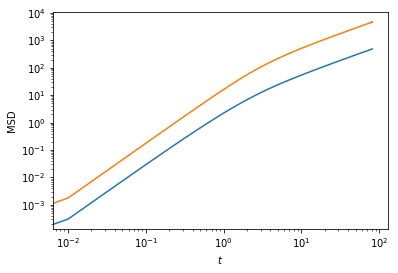

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$t$")
plt.ylabel("MSD")
mean = msd_passive.mean(axis=0)
std = msd_passive.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2:].sum(axis=1),yerr=std[:,2:].sum(axis=1));
mean = msd_active.mean(axis=0)
std = msd_active.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2:].sum(axis=1),yerr=std[:,2:].sum(axis=1));

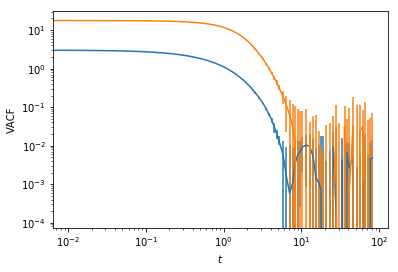

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$t$")
plt.ylabel("VACF")
mean = vacf_passive.mean(axis=0)
std = vacf_passive.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2],yerr=std[:,2]);
mean = vacf_active.mean(axis=0)
std = vacf_active.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2],yerr=std[:,2]);

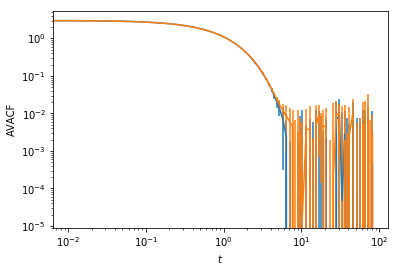

In [8]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$t$")
plt.ylabel("AVACF")
mean = avacf_passive.mean(axis=0)
std = avacf_passive.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2],yerr=std[:,2]);
mean = avacf_active.mean(axis=0)
std = avacf_active.std(axis=0,ddof=1)
plt.errorbar(mean[:,0],mean[:,2],yerr=std[:,2]);